# task1 PyTorch的基本概念

## 安装

参考
[WIn10+Anaconda 环境下安装 PyTorch 避坑指南](https://blog.csdn.net/red_stone1/article/details/86669362)

虽然本来安装了anaconda，但是最后还是用pip安装成功的，不过没有出现参考文章中import torchvision 报错的情况，直接就成功了

## 简单操作

In [55]:
import torch
import torchvision
from __future__ import print_function

创建一个没有初始化的5*3矩阵：

In [5]:
x = torch.empty(5, 3)
print(x)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 5.4370e-43, 0.0000e+00],
        [0.0000e+00, 5.8574e-43, 0.0000e+00]])


实现一个只有输入层、单隐藏层、输出层的一个神经网络。假设样本数为64个，输入维度为1000，隐藏层为100，输出层为10。

参考[简单神经网络在Numpy和Pytorch上的实现](https://blog.csdn.net/herosunly/article/details/88949873)

In [7]:
num_samples = 64 # N
dim_in, dim_hid, dim_out = 1000, 100, 10  # IN H OUT
x = torch.randn(num_samples, dim_in)  #  N * IN
y = torch.randn(num_samples, dim_out) #  N * OUT

w1 = torch.randn(dim_in, dim_hid)     # IN * H
w2 = torch.randn(dim_hid, dim_out)    #  H * OUT

eta = 1e-6
for i in range(1000):
    #Forward pass
    h = x @ w1                              # N * H
    h_relu = h.clamp(min = 0)               # N * H
    y_pred = h_relu @ w2                    # N * OUT

    #Loss
    loss = (y_pred - y).pow(2).sum().item()
    print('times is {}, loss is {}'.format(i, loss))

    #Backward pass
    grad_y_pred = 2.0 * (y_pred - y)        # N * OUT
    grad_w2 = (h_relu.t()) @ (grad_y_pred) #H * OUT = (H * N) * (N * OUT)，其中(H * N) = (N * H).T

    grad_h_relu = grad_y_pred @ ((w2.t()))# N * H = (N * OUT) * (OUT * H)，其中(OUT * H) = (H * OUT).T
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0

    grad_w1 = (x.t()) @ (grad_h)  # IN * H = （IN * N） * (N * H)

    w1 = w1 - eta * grad_w1
    w2 = w2 - eta * grad_w2

times is 0, loss is 24090022.0
times is 1, loss is 18525898.0
times is 2, loss is 16259958.0
times is 3, loss is 15044279.0
times is 4, loss is 13902393.0
times is 5, loss is 12201958.0
times is 6, loss is 10098992.0
times is 7, loss is 7769329.5
times is 8, loss is 5693966.0
times is 9, loss is 4005826.75
times is 10, loss is 2786802.5
times is 11, loss is 1940883.0
times is 12, loss is 1378414.25
times is 13, loss is 1004570.5
times is 14, loss is 755964.875
times is 15, loss is 586827.0625
times is 16, loss is 469078.375
times is 17, loss is 384281.25
times is 18, loss is 321295.34375
times is 19, loss is 273031.125
times is 20, loss is 234842.75
times is 21, loss is 203984.265625
times is 22, loss is 178524.375
times is 23, loss is 157179.46875
times is 24, loss is 139055.671875
times is 25, loss is 123540.125
times is 26, loss is 110163.03125
times is 27, loss is 98520.3359375
times is 28, loss is 88336.375
times is 29, loss is 79392.3984375
times is 30, loss is 71503.2421875
time

times is 252, loss is 0.08665202558040619
times is 253, loss is 0.08224596828222275
times is 254, loss is 0.07809236645698547
times is 255, loss is 0.07413729280233383
times is 256, loss is 0.07041323184967041
times is 257, loss is 0.06681721657514572
times is 258, loss is 0.06344544142484665
times is 259, loss is 0.060241587460041046
times is 260, loss is 0.05718967318534851
times is 261, loss is 0.054306406527757645
times is 262, loss is 0.051545996218919754
times is 263, loss is 0.048963580280542374
times is 264, loss is 0.04650399833917618
times is 265, loss is 0.04416145756840706
times is 266, loss is 0.04192472994327545
times is 267, loss is 0.03980870544910431
times is 268, loss is 0.03782244771718979
times is 269, loss is 0.035906072705984116
times is 270, loss is 0.03411024063825607
times is 271, loss is 0.0324016772210598
times is 272, loss is 0.03078596107661724
times is 273, loss is 0.029234783723950386
times is 274, loss is 0.027781367301940918
times is 275, loss is 0.0263

times is 488, loss is 3.500821549096145e-05
times is 489, loss is 3.461224332568236e-05
times is 490, loss is 3.408803604543209e-05
times is 491, loss is 3.370834019733593e-05
times is 492, loss is 3.335346991661936e-05
times is 493, loss is 3.291064786026254e-05
times is 494, loss is 3.2601536076981574e-05
times is 495, loss is 3.2163130526896566e-05
times is 496, loss is 3.185031164321117e-05
times is 497, loss is 3.135907172691077e-05
times is 498, loss is 3.0967057682573795e-05
times is 499, loss is 3.072461186093278e-05
times is 500, loss is 3.0286910259746946e-05
times is 501, loss is 2.99294351862045e-05
times is 502, loss is 2.9568347599706613e-05
times is 503, loss is 2.9104923669365235e-05
times is 504, loss is 2.8681743060587905e-05
times is 505, loss is 2.8423482945072465e-05
times is 506, loss is 2.8136819310020655e-05
times is 507, loss is 2.796884837152902e-05
times is 508, loss is 2.7574867999646813e-05
times is 509, loss is 2.7182924895896576e-05
times is 510, loss is 

times is 723, loss is 7.274953532032669e-06
times is 724, loss is 7.242019819386769e-06
times is 725, loss is 7.220886800496373e-06
times is 726, loss is 7.187532446550904e-06
times is 727, loss is 7.204346729849931e-06
times is 728, loss is 7.1669023782305885e-06
times is 729, loss is 7.1078156906878576e-06
times is 730, loss is 7.081429430400021e-06
times is 731, loss is 7.0309697548509575e-06
times is 732, loss is 6.998581739026122e-06
times is 733, loss is 7.009123237367021e-06
times is 734, loss is 7.00954342391924e-06
times is 735, loss is 6.973459221626399e-06
times is 736, loss is 6.982230843277648e-06
times is 737, loss is 6.928451057319762e-06
times is 738, loss is 6.876944553368958e-06
times is 739, loss is 6.878016392874997e-06
times is 740, loss is 6.771955668227747e-06
times is 741, loss is 6.774605026294012e-06
times is 742, loss is 6.806131750636268e-06
times is 743, loss is 6.74552802593098e-06
times is 744, loss is 6.744709025952034e-06
times is 745, loss is 6.7416976

times is 965, loss is 3.5385733099246863e-06
times is 966, loss is 3.5281063901493326e-06
times is 967, loss is 3.5078437576885335e-06
times is 968, loss is 3.4925135423691245e-06
times is 969, loss is 3.488970151011017e-06
times is 970, loss is 3.4793702070601285e-06
times is 971, loss is 3.478344979157555e-06
times is 972, loss is 3.4621953091118485e-06
times is 973, loss is 3.4529157346696593e-06
times is 974, loss is 3.4602835512487218e-06
times is 975, loss is 3.4432925986038754e-06
times is 976, loss is 3.4290560506633483e-06
times is 977, loss is 3.4276740734640043e-06
times is 978, loss is 3.4210170269943774e-06
times is 979, loss is 3.412165142435697e-06
times is 980, loss is 3.4152446914959e-06
times is 981, loss is 3.4026234061457217e-06
times is 982, loss is 3.3997093851212412e-06
times is 983, loss is 3.395565272512613e-06
times is 984, loss is 3.3968203752010595e-06
times is 985, loss is 3.398530452614068e-06
times is 986, loss is 3.4033450901915785e-06
times is 987, loss

# task2 设立计算图并自动计算

## 一、线性回归 y = w1*x1 + w2*x2

In [20]:
w1 = 4
w2 = -3

$\operatorname{loss}=\frac{1}{2n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right)^{2}$

$\frac{dloss}{d w_{1}}=\frac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right) \cdot x_{1_{i}}$

$\frac{dloss}{d w_{2}}=\frac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right) \cdot x_{2_{i}}$

### 1、numpy方式

In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
x_data = np.array([[1,2,3],
                   [3,1,2]])
y_data = w1 * x_data[0] + w2 * x_data[1]

In [39]:
y_data

array([-5,  5,  6])

In [45]:
epochs = 10
rate = 0.1
w1_ = 0
w2_ = 0
cost = []

In [46]:
for epoch in range(epochs):
    y_ = w1_ * x_data[0] + w2_ * x_data[1]
    #计算损失
    loss = np.average((y_ - y_data)**2)/2.0
    cost.append(loss)
    
    #计算梯度
    dw1 = (y_ - y_data) @ x_data[0].T/(x_data.shape[0])
    dw2 = (y_ - y_data) @ x_data[1].T/(x_data.shape[0])
    
    #参数更新
    w1_ = w1_ - rate * dw1
    w2_ = w2_ - rate * dw2
    print(w1_,w2_)

1.1500000000000001 0.1
1.44 -0.5025000000000001
1.8583749999999999 -0.84275
2.171025 -1.17493125
2.4475196875000003 -1.4465431250000003
2.6798546250000004 -1.6800987656250002
2.87801070859375 -1.8779496734375003
3.0462755329687505 -2.0462907917578126
3.189342595357422 -2.1893387806601567
3.310939107970313 -2.310940061644629


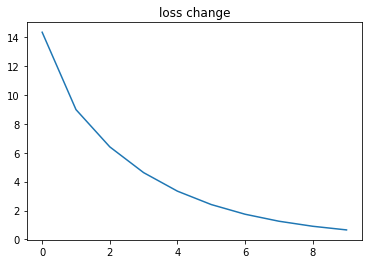

In [53]:
plt.figure()
plt.plot(range(epochs), cost)
plt.title(u"loss change")
plt.show()

### torch 方式

In [60]:
from torch.autograd import Variable

In [56]:
torch.manual_seed(2)

In [62]:
x_data = Variable(torch.Tensor([[1.0,3.0],[2.0,1.0],[3.0,2.0]]))
y_data = Variable(torch.Tensor([[-5.0],[5.0],[6.0]]))

In [63]:
x_data

tensor([[1., 3.],
        [2., 1.],
        [3., 2.]])

In [64]:
y_data

tensor([[-5.],
        [ 5.],
        [ 6.]])

In [65]:
epochs = 10
rate = 0.1
w = Variable(torch.FloatTensor([[0],[0]]))
cost = []

In [69]:
x_data[0]

tensor([1., 3.])

In [68]:
w[0] * x_data[0] + w[1] * x_data[1]

tensor([0., 0.])

In [ ]:
for epoch in range(epochs):
    y_ = w1_ * x_data[0] + w2_ * x_data[1]